In [1]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import OneClassSVM
from robocop import fetch_events,evaluate_and_report2,build_pid_windows,evaluate_and_report,build_pid_and_handle_windows
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
NUM_SYSCALLS = 473 + 1 # State Of PADDING
PADDING_SYSCALL = 473
PADDING_OBJ = {'id': 0,
   'ts': 0,
   'pid': 0,
   'tid': 0,
   'syscall_num': PADDING_SYSCALL,
   'process_name': 0,
   'handle_operation': None,
   'handle_1_val': None,
   'handle_2_val': None,
   'ret_handle': None,
   'closed_handle': None,
   'handle_1_access': None,
   'handle_2_access': None,
   'handle_1_access_mode': None,
   'handle_2_access_mode': None,}
NGRAM = 4
NU = 0.01
GAMMA = 0.01

In [3]:
encoder = OneHotEncoder(
    categories=[np.arange(NUM_SYSCALLS)] * NGRAM,
    sparse_output=False
)

encoder.fit(np.zeros((1, NGRAM), dtype=np.int32))


OneHotEncoder(categories=[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106...
       390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402,
       403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415,
       416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428,
       429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441,
       442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454,
       455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467,
       468, 469, 470, 471, 472, 473])],
              sparse_output=False)

In [4]:
def extract_features(window):
    x = np.array(window,dtype=np.int32).reshape(1,-1)
    return encoder.transform(x)[0]

def build_X(handles_seq, syscall_to_id=None): 
    vectors = [] 
    mapping = []   # <-- הוספת mapping
    for handles in handles_seq:
        buf = []
        for handle in handles:
            if len(buf) == NGRAM: 
                vectors.append(extract_features(buf))
                mapping.append(handles)  
                buf = buf[1:]
            buf.append(handle["syscall_num"])
        
        if len(buf) == NGRAM: 
            vectors.append(extract_features(buf))
            mapping.append(handles)
        else:
            for i in range(NGRAM - len(buf)): 
                buf.append(PADDING_SYSCALL)
            vectors.append(extract_features(buf))
            mapping.append(handles)

    return vectors, mapping   


In [5]:
train_events = fetch_events("test = '1' OR test = '2' OR test='15' OR test='14' OR test='15' OR test='16' OR test='17'")

In [6]:
len(train_events)

660931

In [7]:
train_windows = build_pid_and_handle_windows(train_events)
train_windows


[[{'id': 341,
   'ts': 1768424195751936.0,
   'pid': 992,
   'tid': 6200,
   'syscall_num': 66,
   'process_name': 'ation\\chrome.exe',
   'handle_operation': 1,
   'handle_1_val': 3336,
   'handle_2_val': None,
   'ret_handle': 6960,
   'closed_handle': None,
   'handle_1_access': 2,
   'handle_2_access': None,
   'handle_1_access_mode': 224,
   'handle_2_access_mode': None,
   'name': 'NtDuplicateToken'},
  {'id': 342,
   'ts': 1768424195751936.0,
   'pid': 992,
   'tid': 6200,
   'syscall_num': 13,
   'process_name': 'ation\\chrome.exe',
   'handle_operation': None,
   'handle_1_val': 6960,
   'handle_2_val': None,
   'ret_handle': None,
   'closed_handle': None,
   'handle_1_access': 4,
   'handle_2_access': None,
   'handle_1_access_mode': 224,
   'handle_2_access_mode': None,
   'name': 'NtSetInformationThread'},
  {'id': 343,
   'ts': 1768424195751936.0,
   'pid': 992,
   'tid': 6200,
   'syscall_num': 15,
   'process_name': 'ation\\chrome.exe',
   'handle_operation': None,
   '

In [8]:
X_train,mapping = build_X(train_windows)
print(X_train[0])
print(X_train[0].shape)
print(mapping[0])

[0. 0. 0. ... 0. 0. 1.]
(1896,)
[{'id': 341, 'ts': 1768424195751936.0, 'pid': 992, 'tid': 6200, 'syscall_num': 66, 'process_name': 'ation\\chrome.exe', 'handle_operation': 1, 'handle_1_val': 3336, 'handle_2_val': None, 'ret_handle': 6960, 'closed_handle': None, 'handle_1_access': 2, 'handle_2_access': None, 'handle_1_access_mode': 224, 'handle_2_access_mode': None, 'name': 'NtDuplicateToken'}, {'id': 342, 'ts': 1768424195751936.0, 'pid': 992, 'tid': 6200, 'syscall_num': 13, 'process_name': 'ation\\chrome.exe', 'handle_operation': None, 'handle_1_val': 6960, 'handle_2_val': None, 'ret_handle': None, 'closed_handle': None, 'handle_1_access': 4, 'handle_2_access': None, 'handle_1_access_mode': 224, 'handle_2_access_mode': None, 'name': 'NtSetInformationThread'}, {'id': 343, 'ts': 1768424195751936.0, 'pid': 992, 'tid': 6200, 'syscall_num': 15, 'process_name': 'ation\\chrome.exe', 'handle_operation': None, 'handle_1_val': None, 'handle_2_val': None, 'ret_handle': None, 'closed_handle': 6960

In [9]:
len(train_events)

660931

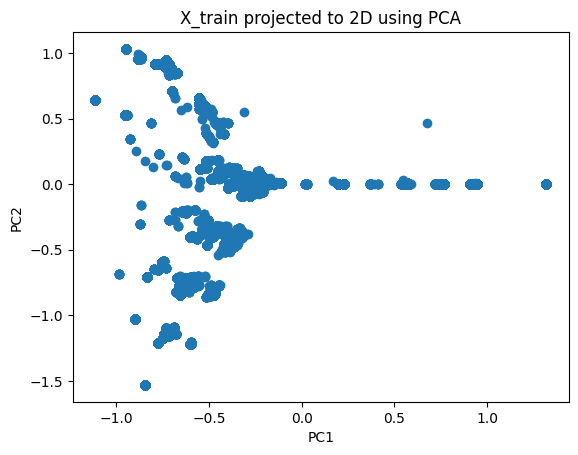

In [10]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_train)

plt.figure()
plt.scatter(X_2d[:, 0], X_2d[:, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("X_train projected to 2D using PCA")
plt.show()

In [11]:
virus_events = fetch_events("test = '8'",100_000)
virus_windows = build_pid_and_handle_windows(virus_events)
X_virus,virus_mapping = build_X(virus_windows)

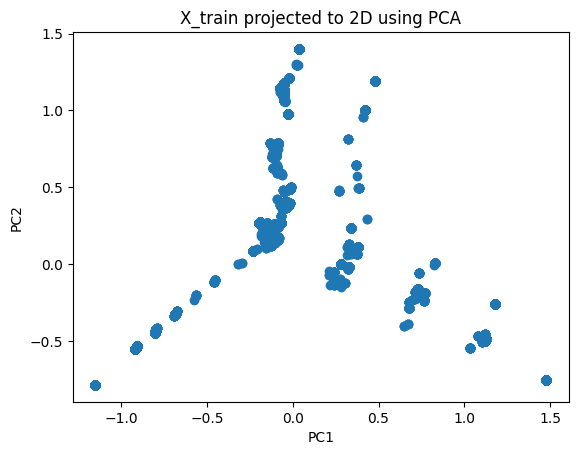

In [12]:
X_2d = pca.fit_transform(X_virus)

plt.figure()
plt.scatter(X_2d[:, 0], X_2d[:, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("X_train projected to 2D using PCA")
plt.show()

In [13]:
normal_events = fetch_events("test = '15' OR test ='16' OR test='17'" ,500_000)
normal_windows = build_pid_and_handle_windows(normal_events)
X_normal,normla_mapping= build_X(normal_windows)

In [14]:
len(normal_windows)

9102

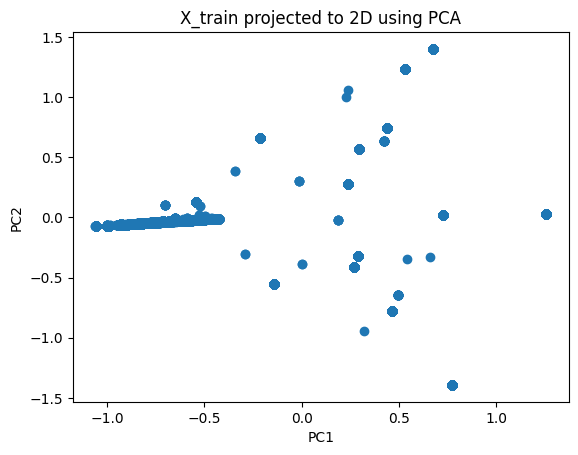

In [15]:
X_2d = pca.fit_transform(X_normal)

plt.figure()
plt.scatter(X_2d[:, 0], X_2d[:, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("X_train projected to 2D using PCA")
plt.show()

In [16]:
from collections import defaultdict
import robocop
def evaluate_and_report(label: str, windows, X, model, scaler):
    X_scaled = scaler.transform(X)
    preds = model.predict(X_scaled)                 # +1 normal, -1 anomaly
    scores = model.decision_function(X_scaled)      # more negative => more anomalous
    totatl = [] 

    for i, (p, s) in enumerate(zip(preds, scores)):
        if p != -1:
            continue
        
        w = windows[i]
        proc_name = w[0]["process_name"]
        pid = w[0]["pid"]
        syscalls = [robocop.convert_syscall_num_to_string(e["syscall_num"]) for e in w]

        totatl.append({
                "pid": pid,
                "name" : proc_name,
                "score": float(s),
                "syscalls": syscalls,
            })

    return totatl


In [17]:
import matplotlib.pyplot as plt

def plot_process_all_scores(results, process_name):
    scores = [r["score"] for r in results if r["name"] == process_name]

    if not scores:
        print(f"No scores found for process: {process_name}")
        return

    plt.figure(figsize=(10, 4))
    plt.plot(scores, marker='o')
    plt.axhline(0, linestyle="--")

    plt.title(f"OCSVM scores for process: {process_name}")
    plt.xlabel("Window index")
    plt.ylabel("OCSVM score (lower = more anomalous)")

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [18]:
nu = 0.05
gamma = 0.0001
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
model = OneClassSVM(kernel="rbf", nu=nu, gamma=gamma)
model.fit(X_train_scaled)


In [ ]:
normal_report = evaluate_and_report(
    label="NORMAL",
    windows=normla_mapping,
    X=X_normal,
    model=model,
    scaler=scaler
)
virus_report = evaluate_and_report(
    label="VIRUS",
    windows=virus_mapping,
    X=X_virus,
    model=model,
    scaler=scaler
)
print(f"NU : {nu} GAMMA:{gamma} , VIRUS:{len(virus_report)} NORMAL:{len(normal_report)}")